In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import attr
import bz2
import ujson
import os
import umap
import random
import math

import numpy as np
import altair as alt
import pandas as pd

from glob import glob
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

from scipy import stats
from itertools import islice
from scipy.cluster.hierarchy import linkage, dendrogram
from collections import Counter
from multiprocessing import Pool
from functools import partial

In [3]:
@attr.s
class Dataset:
    
    root = attr.ib()
    
    def paths(self):
        return glob(os.path.join(self.root, '*.bz2'))
    
    def novels(self):
        for path in tqdm(self.paths()):
            with bz2.open(path) as fh:
                for line in fh:
                    yield ujson.loads(line)

In [4]:
ds = Dataset('../../data/top200-100b.json/')

In [5]:
novels = list(ds.novels())

100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


In [6]:
def count_df(token, min_count=50000):
    
    rows = []
    for n in novels:
        if n['word_count'] > min_count and min(n['counts'][token]):
            rows.append((n['corpus'], n['identifier'], n['pub_year'], n['counts'][token]))
            
    return pd.DataFrame(rows, columns=('corpus', 'identifier', 'pub_year', 'counts'))

In [7]:
def cluster_df(df, n_clusters=4):
    
    counts = np.stack(df.counts)
    counts = counts / counts.mean(1, keepdims=True)
    
    model = AgglomerativeClustering(n_clusters=n_clusters)
    model.fit(counts)
    
    return counts, model

In [12]:
def plot_clusters(counts, model):
    
    plt.figure(figsize=(10,6))
    
    groups = [
        (cid, counts[model.labels_==cid])
        for cid in np.unique(model.labels_)
    ]
    
    max_size = max([len(gc) for _, gc in groups])
    
    groups = sorted(groups, key=lambda g: len(g[1]), reverse=True)
    
    for cid, gc in groups:
        lw = 8 * (len(gc) / max_size)
        label = f'{cid} ({len(gc)})'
        plt.plot(gc.mean(0), label=label)

In [13]:
def plot_token_clusters(token, n_clusters):
    df = count_df(token)
    counts, model = cluster_df(df, n_clusters)
    plot_clusters(counts, model)

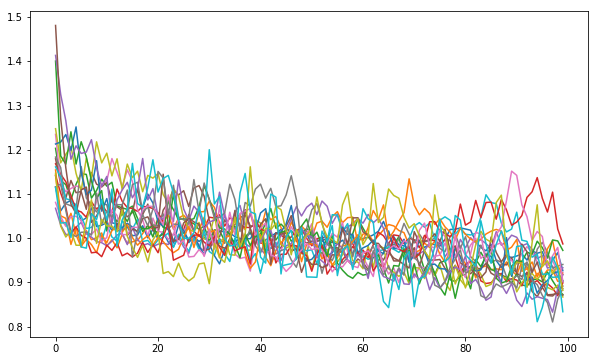

In [15]:
plot_token_clusters('a', 20)